In [1]:
import gym
from gym import spaces
import numpy as np

In [2]:
# %load "~/helpers.py"
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", module="matplotlib")

# Styles
jtplot.style('oceans16')
jtplot.style('grade3', context='paper', fscale=1.4)
jtplot.figsize(aspect=1.2)
jtplot.style(ticks=False, grid=False)

# Debug
from IPython.core.debugger import set_trace


In [3]:
%load_ext autoreload
%autoreload 2
from rl_teacher.particle import Particle

In [4]:
env = gym.make('Particle-v0')
obs = env.reset()
print(obs)


[2017-06-20 17:50:59,058] Making new env: Particle-v0


[ 0.64358474 -0.51719982]


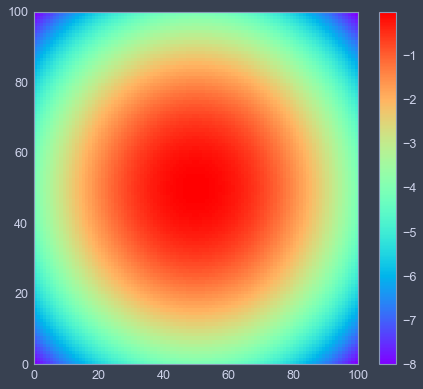

In [5]:
def show_heatmap(rew_fn):
    n_steps = 100j
    rng = 2
    grid = np.mgrid[-rng:rng:n_steps, -rng:rng:n_steps]

    # Map the reward onto a heatmap
    rew_vec = np.vectorize(lambda x, y: rew_fn([x, y]))
    heatmap = rew_vec(grid[0], grid[1])
    
    fig, ax = plt.subplots()
    im = ax.pcolormesh(heatmap, cmap = 'rainbow')
    fig.colorbar(im)
    plt.show()

def true_reward(loc):
    return -np.dot(loc, loc)

show_heatmap(true_reward)

In [6]:
# Test random agent
env = gym.make('Particle-v0')
rewards = []

for i in range(20000):
    obs = env.reset()
    obs, reward, done, info = env.step(np.random.randn(2))
    rewards.append(reward)

print("Average rewards for RandomAgent: %s" % np.mean(rewards))

[2017-06-20 17:51:00,073] Making new env: Particle-v0


Average rewards for RandomAgent: -3.97465111258


In [7]:
%load_ext autoreload
%autoreload 2
from rl_teacher.agent.trpo.run_trpo_mujoco import train


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using TensorFlow backend.


In [8]:
import rl_teacher.agent.trpo.run_trpo_mujoco

class RewardCollector(object):
    def __init__(self):
        self.training_paths = []

    def predict_reward(self, path):
        self.training_paths.append(path)
        return path["original_reward"]

predictor = RewardCollector()
rl_teacher.agent.trpo.run_trpo_mujoco.train(
        num_timesteps=10000,
        env_id='Particle-v0',
        seed=1,
        predictor=predictor
    )

[2017-06-20 17:51:17,887] Making new env: Particle-v0
/Users/tombrown/anaconda3/envs/openai/lib/python3.5/site-packages/keras/engine/topology.py:583: UserWarning: Class `rl_teacher.agent.common.keras_util.ConcatFixedStd` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)
Rolling out:   6%|▌         | 291/5000 [00:00<00:01, 2885.35it/s]

=: doing rollouts


Rolling out: 5001it [00:01, 2995.97it/s]                          


done in 1.671 seconds
Computing advantage
Fitting baseline
{'nit': 26, 'funcalls': 33, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'warnflag': 1}
Fitting policy
=: fitting policy
lagrange multiplier: 50.7075261115 gnorm: 13.8242
fval before 11.0885252637
a/e/r 0.97379039817 1.01417421949 0.960180587766
fval after 10.1147348655
success True
done in 0.550 seconds
**** Iteration 0 *****
----------------------------------
| NumEpBatch         | 1.67e+03  |
| EpRewMean          | -15.6     |
| EpRewSEM           | 0.334     |
| EpRewMax           | -0.364    |
| EpLenMean          | 3         |
| EpLenMax           | 3         |
| RewPerStep         | -5.21     |
| vf_loss_before     | 2.67      |
| vf_loss_after      | 1         |
| vf_mse_before      | 2.6       |
| vf_mse_after       | 0.933     |
| vf_l2_before       | 0.0699    |
| vf_l2_after        | 0.0716    |
| vf_PredStdevBefore | 0.253     |
| vf_PredStdevAfter  | 0.64      |
| vf_TargStdev       | 11.5      |
| vf_E

Rolling out:   6%|▌         | 282/5000 [00:00<00:01, 2786.42it/s]

=: doing rollouts


Rolling out: 5001it [00:01, 2736.72it/s]                          


done in 1.829 seconds
Computing advantage
Fitting baseline
{'nit': 26, 'funcalls': 32, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'warnflag': 1}
Fitting policy
=: fitting policy
lagrange multiplier: 38.8722061674 gnorm: 10.131
fval before 7.78673015397
a/e/r 0.756903306839 0.777439216633 0.973585189228
fval after 7.02982684713
success True
done in 0.466 seconds
**** Iteration 1 *****
---------------------------------
| NumEpBatch         | 1.67e+03 |
| EpRewMean          | -12.8    |
| EpRewSEM           | 0.261    |
| EpRewMax           | -0.161   |
| EpLenMean          | 3        |
| EpLenMax           | 3        |
| RewPerStep         | -4.26    |
| vf_loss_before     | 1.46     |
| vf_loss_after      | 0.642    |
| vf_mse_before      | 1.39     |
| vf_mse_after       | 0.57     |
| vf_l2_before       | 0.0716   |
| vf_l2_after        | 0.072    |
| vf_PredStdevBefore | 0.634    |
| vf_PredStdevAfter  | 1.02     |
| vf_TargStdev       | 8.98     |
| vf_EV_before       |

In [9]:
stored_training_paths = predictor.training_paths

In [56]:
def sample_segment_from_paths(paths, segment_length=3):
    def _length(path):
        return len(path['observation_raw'])
    
    long_enough_paths = [path for path in paths if _length(path) >= segment_length]
    assert long_enough_paths, "No paths were available to create segments. None were longer than %s steps" % segment_length

    chosen_path = np.random.choice(long_enough_paths)
    start_pos = np.random.randint(0, _length(chosen_path) - segment_length + 1)
    return {k: np.asarray(v[start_pos:(start_pos + segment_length)]) 
               for k, v in chosen_path.items() 
               if k in ['observation_raw', 'action', 'original_reward']
          }

print(sample_segment_from_paths(stored_training_paths))



{'observation_raw': array([[ 0.76693613, -1.86742744],
       [ 0.19092865, -2.21913556],
       [ 0.27564544, -2.59266744]]), 'original_reward': array([-4.96101637, -6.79790484, -5.61189262]), 'action': array([[-0.57600749, -0.35170811],
       [ 0.08471679, -0.37353188],
       [-0.92067832,  0.31323215]], dtype=float32)}


In [35]:
import gym
import numpy as np
import rl_teacher.agent.trpo.run_trpo_mujoco
import tensorflow as tf
from tensorflow.contrib import slim

tf.reset_default_graph()
xavier = tf.contrib.layers.xavier_initializer()

def two_layer_mlp(x, in_size, out_size, h_size, scope="mlp"):
    with tf.variable_scope(scope):
        W1 = tf.get_variable("W1", shape=[in_size, h_size], initializer=xavier)
        b1 = tf.Variable(tf.constant(0.1, shape=[h_size]))

        W2 = tf.get_variable("W2", shape=[h_size, h_size], initializer=xavier)
        b2 = tf.Variable(tf.constant(0.1, shape=[h_size]))

        W3 = tf.get_variable("W3", shape=[h_size, out_size], initializer=xavier)
        b3 = tf.Variable(tf.constant(0.1, shape=[out_size]))

    x = tf.matmul(x, W1) + b1
    x = tf.nn.relu(x)
    
    x = tf.matmul(x, W2) + b2
    x = tf.nn.relu(x)
    
    x = tf.matmul(x, W3) + b3
    return x


sess = tf.InteractiveSession()
batch_size = 1000
training_paths = stored_training_paths[:batch_size]

# Make an environment to determine the sizes of our placeholders
env = gym.make("Particle-v0")
n_timesteps = env.spec.timestep_limit
obs_shape = (batch_size, n_timesteps) + env.observation_space.shape

obs_placeholder = tf.placeholder(dtype=tf.float32,
    shape=obs_shape, name="obs_placeholder")
act_placeholder = tf.placeholder(dtype=tf.float32,
    shape=(batch_size, n_timesteps) + env.action_space.shape, name="act_placeholder")

# Concat the model together
obs = obs_placeholder
act = act_placeholder
batchsize = tf.shape(obs)[0]
timesteps = tf.shape(obs)[1]

obs_shape = obs.shape[2:]
act_shape = act.shape[2:]

obs = tf.reshape(obs, [batchsize * timesteps, obs_shape.num_elements()])
act = tf.reshape(act, [batchsize * timesteps, act_shape.num_elements()])

x = tf.concat([obs, act], axis=1)
reward_pred_op = two_layer_mlp(x, in_size=4, out_size=1, h_size=64, scope="mlp")

# Training
target_placeholder = tf.placeholder(dtype=tf.float32,
    shape=(batch_size, n_timesteps), name="target_placeholder")

loss_op = tf.reduce_mean(tf.square(target_placeholder - reward_pred_op))
train_op = tf.train.AdamOptimizer().minimize(loss_op)

sess.run(tf.global_variables_initializer())

obs = np.asarray([path["observation_raw"] for path in training_paths])
acts = np.asarray([path["action"] for path in training_paths])
targets = np.asarray([path["original_reward"] for path in training_paths])

for i in range(20000):
    _, l = sess.run([train_op, loss_op], feed_dict={
        obs_placeholder: obs,
        act_placeholder: acts,
        target_placeholder: targets,
    })
    if i % 1000 == 0:            
        print(l)

print("obs: ", obs)
print("act: ", acts)
print("targets: ", targets)

reward_pred = sess.run(reward_pred_op, feed_dict={
    obs_placeholder: obs,
    act_placeholder: acts,
})
locs = obs + acts

print("Finished")


[2017-06-20 18:02:55,821] Making new env: Particle-v0


ValueError: Dimensions must be equal, but are 1000 and 3000 for 'sub' (op: 'Sub') with input shapes: [1000,3], [3000,1].

In [13]:
print("obs: ", obs)
print("act: ", acts)
print("targets: ", targets)
print()

print(-np.sum(np.square(obs + acts), axis=2))

obs:  [[[-1.10593508 -1.65451545]]

 [[-1.01701414  0.63736181]]

 [[-1.11036305  0.18121427]]

 ..., 
 [[ 0.74546999 -0.34324526]]

 [[-0.04732753 -0.17284434]]

 [[-0.80118853  1.25478427]]]
act:  [[[-2.36346865  1.13534534]]

 [[-1.04991126  1.76675367]]

 [[ 0.43073639 -0.50344217]]

 ..., 
 [[-1.41778421  1.29434264]]

 [[ 0.05386522  0.47275621]]

 [[-1.34501255 -0.34269553]]]
targets:  [[ -1.23062998e+01]
 [ -1.00519519e+01]
 [ -5.65723220e-01]
 [ -1.06447985e+00]
 [ -8.05945370e+00]
 [ -2.16204418e+00]
 [ -1.14161668e+00]
 [ -2.45419065e+00]
 [ -2.76592816e+00]
 [ -1.46073418e+00]
 [ -2.38625953e+00]
 [ -2.03445198e+00]
 [ -8.05303079e-01]
 [ -4.44401504e+00]
 [ -1.44923976e+00]
 [ -9.52679852e-01]
 [ -8.23636655e+00]
 [ -2.45554369e+00]
 [ -2.38773452e+00]
 [ -2.57206342e-01]
 [ -1.14584705e+00]
 [ -5.27099605e-01]
 [ -6.06170947e+00]
 [ -5.54830194e-01]
 [ -3.53809887e+00]
 [ -2.13229169e+00]
 [ -4.56299056e-01]
 [ -3.95935105e-01]
 [ -4.19109794e+00]
 [ -4.89466995e+00]
 [ -

In [14]:
reward_pred, x_vals = sess.run([reward_pred_op, x], feed_dict={
    obs_placeholder: obs,
    act_placeholder: acts,
})
# print("x_vals: ", x_vals)

locs = obs + acts

print("Finished")

Finished


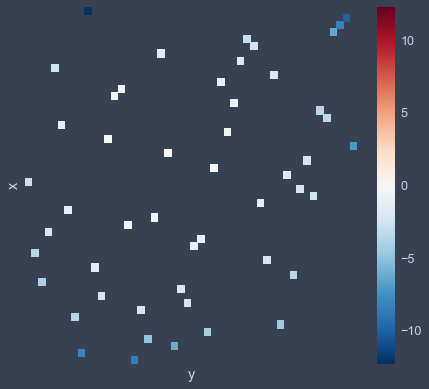

In [15]:
import pandas as pd
n=50
data = pd.DataFrame(data={'x':locs[:n,0,0], 'y':locs[:n,0,1], 'z':reward_pred[:n,0]})
data = data.pivot(index='x', columns='y', values='z')
sns.heatmap(data, xticklabels=False, yticklabels=False)
plt.show()


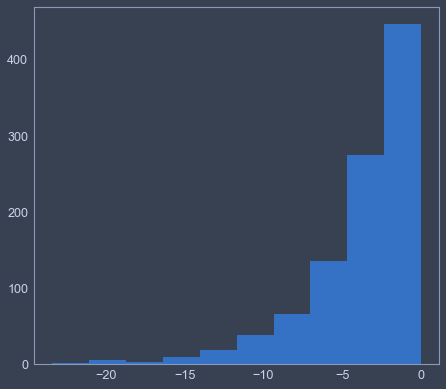

In [17]:
plt.hist(reward_pred[:2000])
plt.show()

In [57]:
xs = locs[:,0,0]
ys = reward_pred[:]
plt.scatter(xs, ys)
plt.show()


[autoreload of rl_teacher failed: Traceback (most recent call last):
  File "/Users/tombrown/anaconda3/envs/openai/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
gym.error.Error: Cannot re-register id: Particle-v0
]


NameError: name 'locs' is not defined

[ 0.16222142  0.16222142  0.97332853]
[  2.76315789   2.76315789  16.57894737]
[  2.76315789   2.76315789  16.57894737]
